<a href="https://colab.research.google.com/github/martinekj/kiv_bit/blob/main/Elliptic_curves_cviceni_bit.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>



```
# Toto je naformátováno jako kód
```

# Cvičení Eliptické křivky
Cílem cvičení je prakticky si vyzkoušet generování soukromého a veřejného klíče a kryptografického algoritmu založeného na eliptických křivkách v konečném tělese.

Začneme tím, že si importujeme knihovny, které budeme potřebovat.

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns



Začneme s jednoduchým příkladem a zvolíme si následující parametry eliptické křivky nad následujícím tělesem $Z_p$:

$a = 1, b = 1, p = 97$

$y^2 = x^3 + x + 1$

kde kde $a,b∈Z_p$ a $D = 4a^3 + 27b^2$ != $0$

Vyzkoušíme si nyní implementovat dvě následující funkce:



1) Doplňte funkci
```
is_point_on_curve(P, a, b, p) -> bool
```
která ověří zda bod P, zadaný jako parametr leží na křivce definované ostatními parametry. Vyzkoušejte pro bod $P = (14, 25)$

2) Doplňte funkci
```
brute_force_generation(p) -> list
```
která vygeneruje všechny body (tj. uspořádané dvojice $\rightarrow$ kartézský součin), které existují na tělese $Z_p$, kde *p* je předáno jako parametr. Funkce vrátí seznam bodů. Vyzkoušejte pro $p = 97$

In [ ]:
def brute_force_generation(p) -> list:
    """
    This function generates all possible points that might lie on the curve
    :param a: parameter of the ec
    :param b: second parameter of the ec
    :param p: mod
    :return: List: list of all possible pairs
    """
    possible_x_values = np.arange(0, p)
    possible_y_values = np.arange(0, p)
    all_possible_pairs = []
    # cartesian product
    for i in range(0, len(possible_x_values)):
        for j in range(0, len(possible_y_values)):
            point = (possible_x_values[i], possible_y_values[j])
            all_possible_pairs.append(point)
    print(f"All ordered pairs: {len(all_possible_pairs)}")
    return all_possible_pairs



def is_point_on_curve(P, a, b, p) -> bool:
    """
    This function determines if the point P given as param "lies" on elliptic curve defined by parameters a and b
    :param P: point (tuple)
    :param a: parameter of the ec
    :param b: second parameter of the ec
    :param p: mod
    :return: True if P lies on the ec
    """

    # equation = y2 (mod p) = x3 + ax + b (mod p)
    x = P[0]
    y = P[1]
    left_side = (y ** 2) % p
    right_side = ((x ** 3) + (a * x) + b) % p
    if left_side == right_side:
        return True
    else:
        return False

a = 1
b = 1
p = 97
P = (14, 25)
P_OK = is_point_on_curve(P, a, b, p)
if P_OK:
  print(f"Bod P={P} leží na křivce")
else:
  print(f"Bod P={P} neleží na křivce")

Bod P=(14, 25) leží na křivce


Vytvoříme nyní funkci, která vygeneruje všechny body, které připadají v úvahu (tj. leží na výše definované křivce) a body si vykreslíme. Z matematického hlediska množina těchto bodů (společně s bodem $∞$) tvoří grupu $E(Z_p)$.

All ordered pairs: 9409
Grupa E(Z97) má 97 prvků


Text(0.5, 1.0, 'Points of EC with parameters a=1 and b=1')

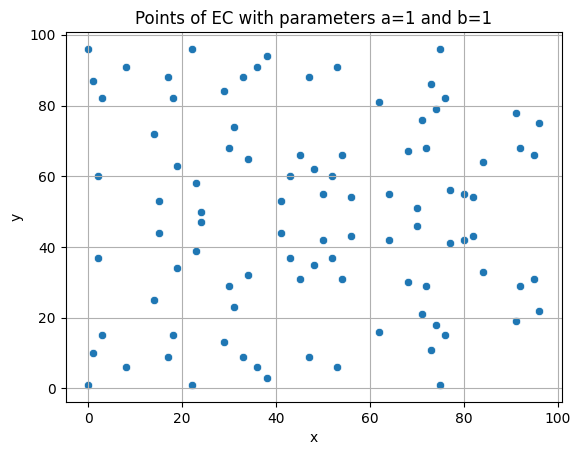

In [ ]:
def generate_points_on_curve(a, b, p) -> list:
    """
    This function generates all relevant points on the curve defined by parameters a and b
    :param a: parameter of the ec
    :param b: second parameter of the ec
    :param p: mod
    :return: List: list of relevant points
    """
    # get all possible points
    all_points = brute_force_generation(p)
    # let's use naive approach to filter out/discard the numbers that do not satisfy the equation
    relevant_points = []
    for point in all_points:
        if is_point_on_curve(point, a, b, p):
            relevant_points.append(point)
    # add also math.inf since it is a point as well
    relevant_points.append((math.inf, math.inf))
    return relevant_points

all_relevant_points = generate_points_on_curve(a, b, p)
grup_size = len(all_relevant_points)
print(f"Grupa E(Z{p}) má {grup_size} prvků")

x_coords = []
y_coords = []
for point in all_relevant_points:
    x_coords.append(point[0])
    y_coords.append(point[1])

elliptic_curve_data = {
    "x": x_coords,
    "y": y_coords
}

ax = sns.scatterplot(data=elliptic_curve_data, x="x", y="y")
plt.grid()
plt.title(f"Points of EC with parameters a={a} and b={b}")
# plt.savefig("elliptic_curve_all_points.png")



Nyní si implementujeme funkci provádějící operaci sčítání dvou bodů. Využijeme informace z přednášky (případně dalších zdrojů). Mějme na paměti, že nepracujeme s reálnými čísly na konečném tělese. Správnost implementace si ověříme např. zde: https://graui.de/code/elliptic2/


In [ ]:
def add_two_ec_points(P, Q, a, p):
    """
    This function adds two points given as param mod p
    :param P: first point (tuple), comprises x and y coords
    :param Q: second point (tuple), comprises x and y coords
    :param a: parameter of the ec
    :param p: mod
    :return: new point (tuple) P+Q
    """

    Px, Py = P[0], P[1]
    Qx, Qy = Q[0], Q[1]


    # inverse_Py = pow(Py, -1, p)
    if Px == Qx and Py == Qy:
        denominator = 2 * Py
        if denominator == 0:
            ## dividing by zero is not defined --> there is no 0^-1 value
            return math.inf
        else:
            inverse_denom = pow(denominator, -1, p)
            # adding two same points
            # s = (3x2p + a) / (2yp) --> slope
            # Xr = s2 – 2xp
            # Yr = s(xp - xr) - yp
            s = ((3 * (Px ** 2) + a) * inverse_denom) % p
            Rx = ((s ** 2) - (2 * Px)) % p
            Ry = (s * (Px - Rx) - Py) % p
    else:
        # adding two different points
        # s = (yp – yq) / (xp – xq) --> slope
        # Xr = s2 – (xp + xq)
        # Yr = s(xp – xr) - yp
        denominator = Px - Qx
        if denominator == 0:
            ## dividing by zero is not defined --> there is no 0^-1 value
            return math.inf
        else:
            inverse_denom = pow(denominator, -1, p)
            s = ((Py - Qy) * inverse_denom) % p
            Rx = ((s ** 2) - (Px + Qx)) % p
            Ry = (s * (Px - Rx) - Py) % p

    return Rx, Ry


Máme-li grupu spolu s definovaným sčítáním, můžeme si demonstrovat generování veřejného a soukromého klíče pro použití v kryptografii. Máme daný předpis pro eliptickou křivku: $y^2 = x^3 + x + 1$

$a = 1, b = 1, p = 97$

Alice zvolí veřejný klíč: tzv. **generátor** $G$, tzn. výchozí bod, který se použije pro vygenerování (cyklické) podgrupy. Každá podgrupa má svůj řád (*order*), značíme $n$. Snažíme se o to, aby řád byl co nejvyšší, ideálně roven počtu bodů grupy (označme např. $r$). K tomu slouží parametr $h$, tzv. *coffactor*, který je definován jako podíl: $h = \frac{n}{r}$. Je-li tento podíl roven 1 máme ideální situaci.

Pro příklad zvolme jako generátor náš bod $P$: $G = (14, 25)$

V následujícím fragmentu kódu vygenerujeme podgrupu. Využijeme k tomu funkci pro součet dvou bodů. Nesmíme zapomenout přidat ještě bod nekonečno. Vypíšeme si následně řád podgrupy na základě bodu $G$ a podgrupu si vykreslíme.

The order of G = 97
[14, 80, 0, 33, 1, 73, 95, 23, 72, 64, 31, 50, 8, 2, 82, 3, 68, 18, 47, 30, 75, 19, 17, 22, 70, 48, 71, 77, 92, 91, 24, 41, 15, 76, 38, 29, 43, 84, 74, 36, 56, 45, 34, 53, 96, 52, 62, 54, 54, 62, 52, 96, 53, 34, 45, 56, 36, 74, 84, 43, 29, 38, 76, 15, 41, 24, 91, 92, 77, 71, 48, 70, 22, 17, 19, 75, 30, 47, 18, 68, 3, 82, 2, 8, 50, 31, 64, 72, 23, 95, 73, 1, 33, 0, 80, 14, inf]
[25, 55, 96, 9, 10, 86, 31, 39, 68, 55, 23, 42, 91, 37, 43, 15, 67, 15, 9, 68, 96, 63, 88, 1, 46, 35, 21, 56, 29, 78, 50, 53, 53, 82, 3, 13, 37, 33, 79, 91, 43, 31, 65, 91, 75, 37, 16, 31, 66, 81, 60, 22, 6, 32, 66, 54, 6, 18, 64, 60, 84, 94, 15, 44, 44, 47, 19, 68, 41, 76, 62, 51, 96, 9, 34, 1, 29, 88, 82, 30, 82, 54, 60, 6, 55, 74, 42, 29, 58, 66, 11, 87, 88, 1, 42, 72, inf]
Ideal situation --> the coffactor h = 1


Text(0.5, 1.0, 'Points of a subgroup generated by\n Generator point (14, 25) and\n EC with parameters 1 and 1')

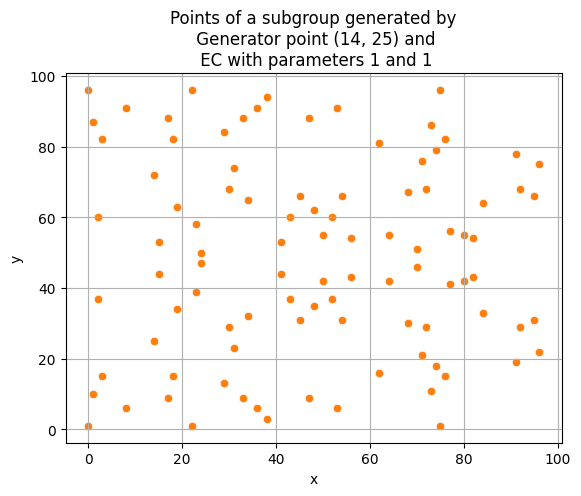

In [ ]:
generator_point = P

subgroup_points_x_coords = []
subgroup_points_y_coords = []
R = generator_point
# append generator as the first point
subgroup_points_x_coords.append(generator_point[0])
subgroup_points_y_coords.append(generator_point[1])

# generate the subgroup
while R is not math.inf:
    newR = add_two_ec_points(P=R, Q=generator_point, a=a, p=p)
    if newR == math.inf:
        subgroup_points_x_coords.append(math.inf)
        subgroup_points_y_coords.append(math.inf)
        break
    subgroup_points_x_coords.append(newR[0])
    subgroup_points_y_coords.append(newR[1])
    R = newR

order_of_G = len(subgroup_points_x_coords)
print(f"The order of G = {order_of_G}")

elliptic_curve_subgroup_data = {
    "x": subgroup_points_x_coords,
    "y": subgroup_points_y_coords
}

print(elliptic_curve_subgroup_data["x"])
print(elliptic_curve_subgroup_data["y"])

# we must include math.inf to have a complete set of points
if order_of_G == len(elliptic_curve_data['x']):
    print(f"Ideal situation --> the coffactor h = 1")
else:
    print(f"The coffactor h = {order_of_G / len(elliptic_curve_data['x'])}")

ax = sns.scatterplot(data=elliptic_curve_data, x="x", y="y")
ax = sns.scatterplot(data=elliptic_curve_subgroup_data, x="x", y="y")
plt.grid()
plt.title(f"Points of a subgroup generated by\n Generator point {generator_point} and\n EC with parameters {a} and {b}")

# K zamyšlení
Zkuste si zvolit jiný generátor a vygenerujte si další podgrupy. Jaký mají řád a cofactor? Jsou stejné nebo jiné? Ujistěte se, že dokážete vysvětlit proč. Proč se snažíme o to, aby řád byl co největší?

# Soukromý klíč
Alice si tedy vygenerovala veřejnou část klíče. Nyní si zvolí klíč soukromý, tzn. číslo $x∈Z_p$. Tento soukromý klíč určuje právě jeden bod $A$ ve vygenerované podgrupě $→ A = xG$

# Diffie-Hellman
Využijeme-li příkladu Diffie-Hellmanovy domluvy klíče v rámci eliptických křivek, pak Alice nasdílí Bobovi všechny parametry, kromě svého soukromého klíče $x$.

Bob použije nasdílené parametry a informace a zvolí si svůj soukromý klíč $y∈Z_p$. Stejným způsobem s vypočte bod $B$, který pak pošle Alici.

Aby oba dosáhli sdíleného klíče (v kontextu eliptických křivek společného bodu na křivce) musí oba udělat následující operace:

1) Alice spočte bod $S_B = xB$

2) Bob spočte bod $S_A = yA$

Tím pádem mají oba "došli" do společného bodu (označme $S$), protože platí následující:

$S = S_A = S_B = xyG$

Máme tedy sdílený/společný tajný klíč, bez toho aniž by oba znali svůj soukromý klíč (x nebo y).

Toto si nyní naprogramujeme a ověříme.


In [ ]:
generator = (14, 25)
a = 1
b = 1
p = 97

# Alice private key:
x = 13

# Bob's private key:
y = 94

# Alice's part
tmpPoint = generator
for i in range(0, x):
  tmpPoint = add_two_ec_points(generator, tmpPoint, a, p)

pointAlice = tmpPoint
print(f"Point Alice: {pointAlice}")

# Bob's part
tmpPoint = generator
for i in range(0, y):
  tmpPoint = add_two_ec_points(generator, tmpPoint, a, p)

pointBob = tmpPoint
print(f"Point Bob: {pointBob}")

# shared key computation
# Alice's part
tmpPoint = pointBob
for i in range(0, x):
  tmpPoint = add_two_ec_points(pointBob, tmpPoint, a, p)
S_a = tmpPoint

# Bob's part
# Alice's part
tmpPoint = pointAlice
for i in range(0, y):
  tmpPoint = add_two_ec_points(pointAlice, tmpPoint, a, p)
S_b = tmpPoint

print(f"Shared point Alice's parts {S_a}")
print(f"Shared point Bob's part {S_b}")
assert S_a == S_b
S = S_a
print("______________________________________________________")
print(f"Final shared point S = {S}")

Point Alice: (2, 37)
Point Bob: (80, 42)
Shared point Alice's parts (77, 41)
Shared point Bob's part (77, 41)
______________________________________________________
Final shared point S = (77, 41)


# Domácí cvičení
Samostatně vyzkoušejte pro následující parametry:

$a = 25, b = 3, p = 13$

$y^2 = x^3 + 25x + 3$ na tělese $Z_{13}$

Zkuste generovat různé podgrupy na základě různých generátorů. Liší se nějak řád různých podgrup? Zkuste odpovědět proč se liší.